In [90]:
import pickle
import pandas as pd
import numpy as np
import networkx as nx 
import random 
from tqdm import tqdm
import os
from collections import defaultdict

import torch
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_networkx

from torch.utils.data import Dataset,TensorDataset,random_split,SubsetRandomSampler
import torch.optim as optim

import matplotlib.pyplot as plt
from sklearn.model_selection import KFold


from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

In [48]:
DATA_PER_SLIDE_SAVEDIR =  "melanoma_immunotherapy/output/final_features"


In [99]:
suffix=''#1024
#load data
dataset_pyg_savepath = os.path.join(
    DATA_PER_SLIDE_SAVEDIR, 'experiment_1'+suffix, 'patches'+suffix+'_dataset_pyg.pkl'
    )
dataset_pyg = pickle.load(open(dataset_pyg_savepath, 'rb'))

In [100]:
suffix='_512'
dataset_pyg_savepath = os.path.join(
    DATA_PER_SLIDE_SAVEDIR, 'experiment_1'+suffix, 'patches'+suffix+'_dataset_pyg.pkl'
    )
dataset_pyg_512 = pickle.load(open(dataset_pyg_savepath, 'rb'))

In [101]:
suffix='_512_rot30'
dataset_pyg_savepath = os.path.join(
    DATA_PER_SLIDE_SAVEDIR, 'experiment_1'+suffix, 'patches'+suffix+'_dataset_pyg.pkl'
    )
dataset_pyg_512_rot30 = pickle.load(open(dataset_pyg_savepath, 'rb'))

In [102]:
suffix='_2048'
dataset_pyg_savepath = os.path.join(
    DATA_PER_SLIDE_SAVEDIR, 'experiment_1'+suffix, 'patches'+suffix+'_dataset_pyg.pkl'
    )
dataset_pyg_2048 = pickle.load(open(dataset_pyg_savepath, 'rb'))

In [103]:
suffix='_1024_rot30'
dataset_pyg_savepath = os.path.join(
    DATA_PER_SLIDE_SAVEDIR, 'experiment_1'+suffix, 'patches'+suffix+'_dataset_pyg.pkl'
    )
dataset_pyg_1024_rot30 = pickle.load(open(dataset_pyg_savepath, 'rb'))

In [104]:
suffix='_1024_rot15'
dataset_pyg_savepath = os.path.join(
    DATA_PER_SLIDE_SAVEDIR, 'experiment_1'+suffix, 'patches'+suffix+'_dataset_pyg.pkl'
    )
dataset_pyg_1024_rot15 = pickle.load(open(dataset_pyg_savepath, 'rb'))

In [105]:
suffix='_1024_shift512_rot30'
dataset_pyg_savepath = os.path.join(
    DATA_PER_SLIDE_SAVEDIR, 'experiment_1'+suffix, 'patches'+suffix+'_dataset_pyg.pkl'
    )
dataset_pyg_1024_shift512_rot30 = pickle.load(open(dataset_pyg_savepath, 'rb'))

In [106]:
suffix='_1024_shift512_rot45'
dataset_pyg_savepath = os.path.join(
    DATA_PER_SLIDE_SAVEDIR, 'experiment_1'+suffix, 'patches'+suffix+'_dataset_pyg.pkl'
    )
dataset_pyg_1024_shift512_rot45 = pickle.load(open(dataset_pyg_savepath, 'rb'))

In [107]:
dataset_pyg.extend(dataset_pyg_512)
dataset_pyg.extend(dataset_pyg_512_rot30)
dataset_pyg.extend(dataset_pyg_2048)
dataset_pyg.extend(dataset_pyg_1024_rot15)
dataset_pyg.extend(dataset_pyg_1024_rot30)
dataset_pyg.extend(dataset_pyg_1024_shift512_rot30)
dataset_pyg.extend(dataset_pyg_1024_shift512_rot45)

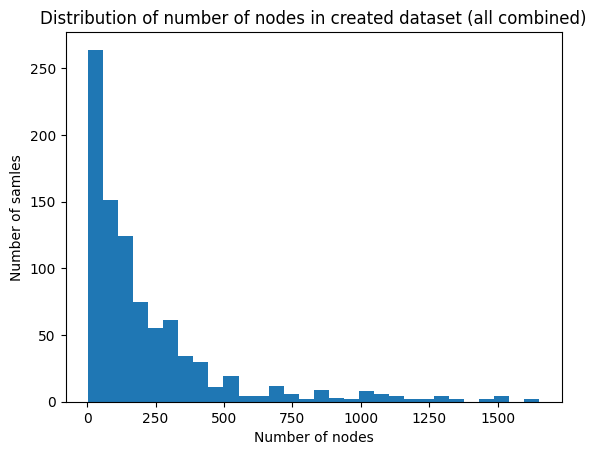

In [109]:
n_nodes = [len(d.x) for d in dataset_pyg]
plt.hist(n_nodes, bins=30)
plt.title("Distribution of number of nodes in created dataset (all combined)")
plt.ylabel("Number of samles")
plt.xlabel("Number of nodes")
plt.savefig('figures/nodes_dist_combined.png')
plt.show()

In [110]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool


class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels_base, num_classes):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(in_channels, hidden_channels_base*8)
        self.conv2 = GCNConv(hidden_channels_base*8, hidden_channels_base*4)
        self.conv3 = GCNConv(hidden_channels_base*4, hidden_channels_base)
        self.lin = Linear(hidden_channels_base, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch) 

        # 3. Apply a final classifier
        x = self.lin(x)
        
        return x

model = GCN(in_channels=115, hidden_channels_base=8, num_classes=2)
print(model)

GCN(
  (conv1): GCNConv(115, 64)
  (conv2): GCNConv(64, 32)
  (conv3): GCNConv(32, 8)
  (lin): Linear(in_features=8, out_features=2, bias=True)
)


In [80]:
from torch_geometric.nn import GATv2Conv
        
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, heads=8):
        super().__init__()
        self.gat1 = GATv2Conv(in_channels, hidden_channels, heads=heads)
        self.gat2 = GATv2Conv(hidden_channels*heads, num_classes, heads=1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        x = self.gat1(x, edge_index)
        x = x.relu()
        x = self.gat2(x, edge_index)
        #x = x.relu()
        #x = self.gat3(x, edge_index)
        
        # 2. Readout layer
        x = global_mean_pool(x, batch) 

        # 3. Apply a final classifier
        x = F.dropout(x, p=DROPOUT, training=self.training)
        #x = self.lin(x)
        x = F.log_softmax(x, dim=1)
        
        return x
model = GAT(in_channels=115, hidden_channels=30, num_classes=2)
print(model)

GAT(
  (gat1): GATv2Conv(115, 30, heads=8)
  (gat2): GATv2Conv(240, 2, heads=1)
)


In [111]:
def train_epoch(model,dataloader,loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    for data in dataloader:
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output,data.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == data.y).sum().item()

    return train_loss,train_correct
  
def valid_epoch(model,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            output = model(data)
            loss=loss_fn(output,data.y)
            valid_loss+=loss.item()
            scores, predictions = torch.max(output.data,1)
            val_correct+=(predictions == data.y).sum().item()

    return valid_loss,val_correct

In [112]:
#from sklearn.model_selection import StratifiedKFold


In [125]:
def plot_roc_curve(true_y, y_prob, fold, AUC):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    label="fold "+str(fold+1)+", AUC="+ str(AUC)
    plt.plot(fpr, tpr, label=label)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

Fold 1
Epoch:1/200 AVG Training Loss:0.650 AVG Test Loss:0.661 AVG Training Acc 66.85 % AVG Test Acc 67.96 %
Epoch:2/200 AVG Training Loss:0.635 AVG Test Loss:0.631 AVG Training Acc 68.10 % AVG Test Acc 67.96 %
Epoch:3/200 AVG Training Loss:0.628 AVG Test Loss:0.630 AVG Training Acc 68.10 % AVG Test Acc 67.96 %
Epoch:4/200 AVG Training Loss:0.621 AVG Test Loss:0.621 AVG Training Acc 68.10 % AVG Test Acc 67.96 %
Epoch:5/200 AVG Training Loss:0.621 AVG Test Loss:0.617 AVG Training Acc 68.10 % AVG Test Acc 67.96 %
Epoch:6/200 AVG Training Loss:0.618 AVG Test Loss:0.612 AVG Training Acc 67.96 % AVG Test Acc 67.96 %
Epoch:7/200 AVG Training Loss:0.610 AVG Test Loss:0.609 AVG Training Acc 68.10 % AVG Test Acc 67.96 %
Epoch:8/200 AVG Training Loss:0.606 AVG Test Loss:0.612 AVG Training Acc 68.10 % AVG Test Acc 67.96 %
Epoch:9/200 AVG Training Loss:0.599 AVG Test Loss:0.603 AVG Training Acc 68.10 % AVG Test Acc 67.96 %
Epoch:10/200 AVG Training Loss:0.596 AVG Test Loss:0.594 AVG Training Acc 6

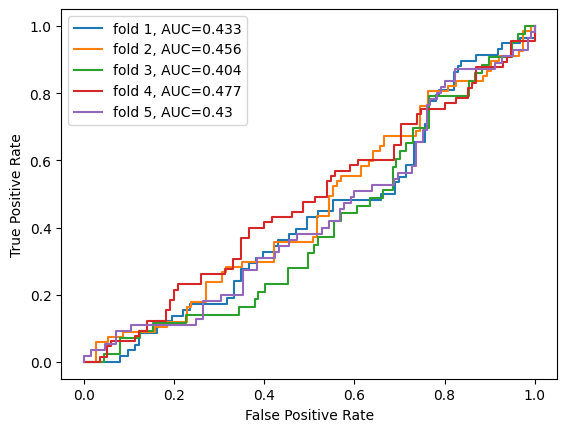

In [126]:
num_epochs = 200
batch_size = 1
criterion = torch.nn.CrossEntropyLoss()

k=5
splits=KFold(n_splits=k,shuffle=True,random_state=42)

history = {'train_loss': {}, 'test_loss': {},'train_acc':{},'test_acc':{}, 'roc_val':{}}
all_AUC = []
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset_pyg)))):

    print('Fold {}'.format(fold + 1))

    history['train_loss'][fold + 1] = []
    history['test_loss'][fold + 1] = []
    history['train_acc'][fold + 1] = []
    history['test_acc'][fold + 1] = []

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset_pyg, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset_pyg, batch_size=batch_size, sampler=test_sampler)


    model = GCN(in_channels=115, hidden_channels_base=8, num_classes=2).double()
    #model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.002)

    for epoch in range(num_epochs):
        train_loss, train_correct=train_epoch(model,train_loader,criterion,optimizer)
        test_loss, test_correct=valid_epoch(model,test_loader,criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
        history['train_loss'][fold + 1].append(train_loss)
        history['test_loss'][fold + 1].append(test_loss)
        history['train_acc'][fold + 1].append(train_acc)
        history['test_acc'][fold + 1].append(test_acc) 
 
    true_y = []
    pred_y = []
    roc_loader = DataLoader([dataset_pyg[index] for index in val_idx], batch_size=1)
    for data in roc_loader:
        output = model(data)
        true_y.append(data.y.item())
        #pred_y.append(output.data.tolist()[0])
        scores, predictions = torch.max(output.data,1)
        pred_y.append(scores.item())
    AUC=roc_auc_score(true_y, pred_y)    
    print(f'model AUC score: {AUC}')
    all_AUC.append(AUC)
    plot_roc_curve(true_y, pred_y, fold, round(AUC,3))
    plt.legend()
plt.savefig('figures/fold_'+str(fold+1)+'_roc_GCN_all.png')
mean_AUC = np.sum(all_AUC)/len(all_AUC)
print("mean:", mean_AUC)

In [116]:
for f in history['train_loss'].keys():
    avg_train_loss = np.mean(history['train_loss'][f])
    avg_test_loss = np.mean(history['test_loss'][f])
    avg_train_acc = np.mean(history['train_acc'][f])
    avg_test_acc = np.mean(history['test_acc'][f])

    print('Performance of {} fold in cross validation'.format(f))
    print("Average Training Loss: {:.4f} \t Average Test Loss: {:.4f} \t Average Training Acc: {:.3f} \t Average Test Acc: {:.3f}".format(avg_train_loss,avg_test_loss,avg_train_acc,avg_test_acc)) 

Performance of 1 fold in cross validation
Average Training Loss: 0.5196 	 Average Test Loss: 0.7148 	 Average Training Acc: 72.341 	 Average Test Acc: 63.116
Performance of 2 fold in cross validation
Average Training Loss: 0.5111 	 Average Test Loss: 0.8199 	 Average Training Acc: 72.635 	 Average Test Acc: 57.448
Performance of 3 fold in cross validation
Average Training Loss: 0.5229 	 Average Test Loss: 0.7059 	 Average Training Acc: 71.565 	 Average Test Acc: 67.233
Performance of 4 fold in cross validation
Average Training Loss: 0.5221 	 Average Test Loss: 0.8085 	 Average Training Acc: 71.801 	 Average Test Acc: 60.700
Performance of 5 fold in cross validation
Average Training Loss: 0.5140 	 Average Test Loss: 0.7759 	 Average Training Acc: 72.144 	 Average Test Acc: 63.200


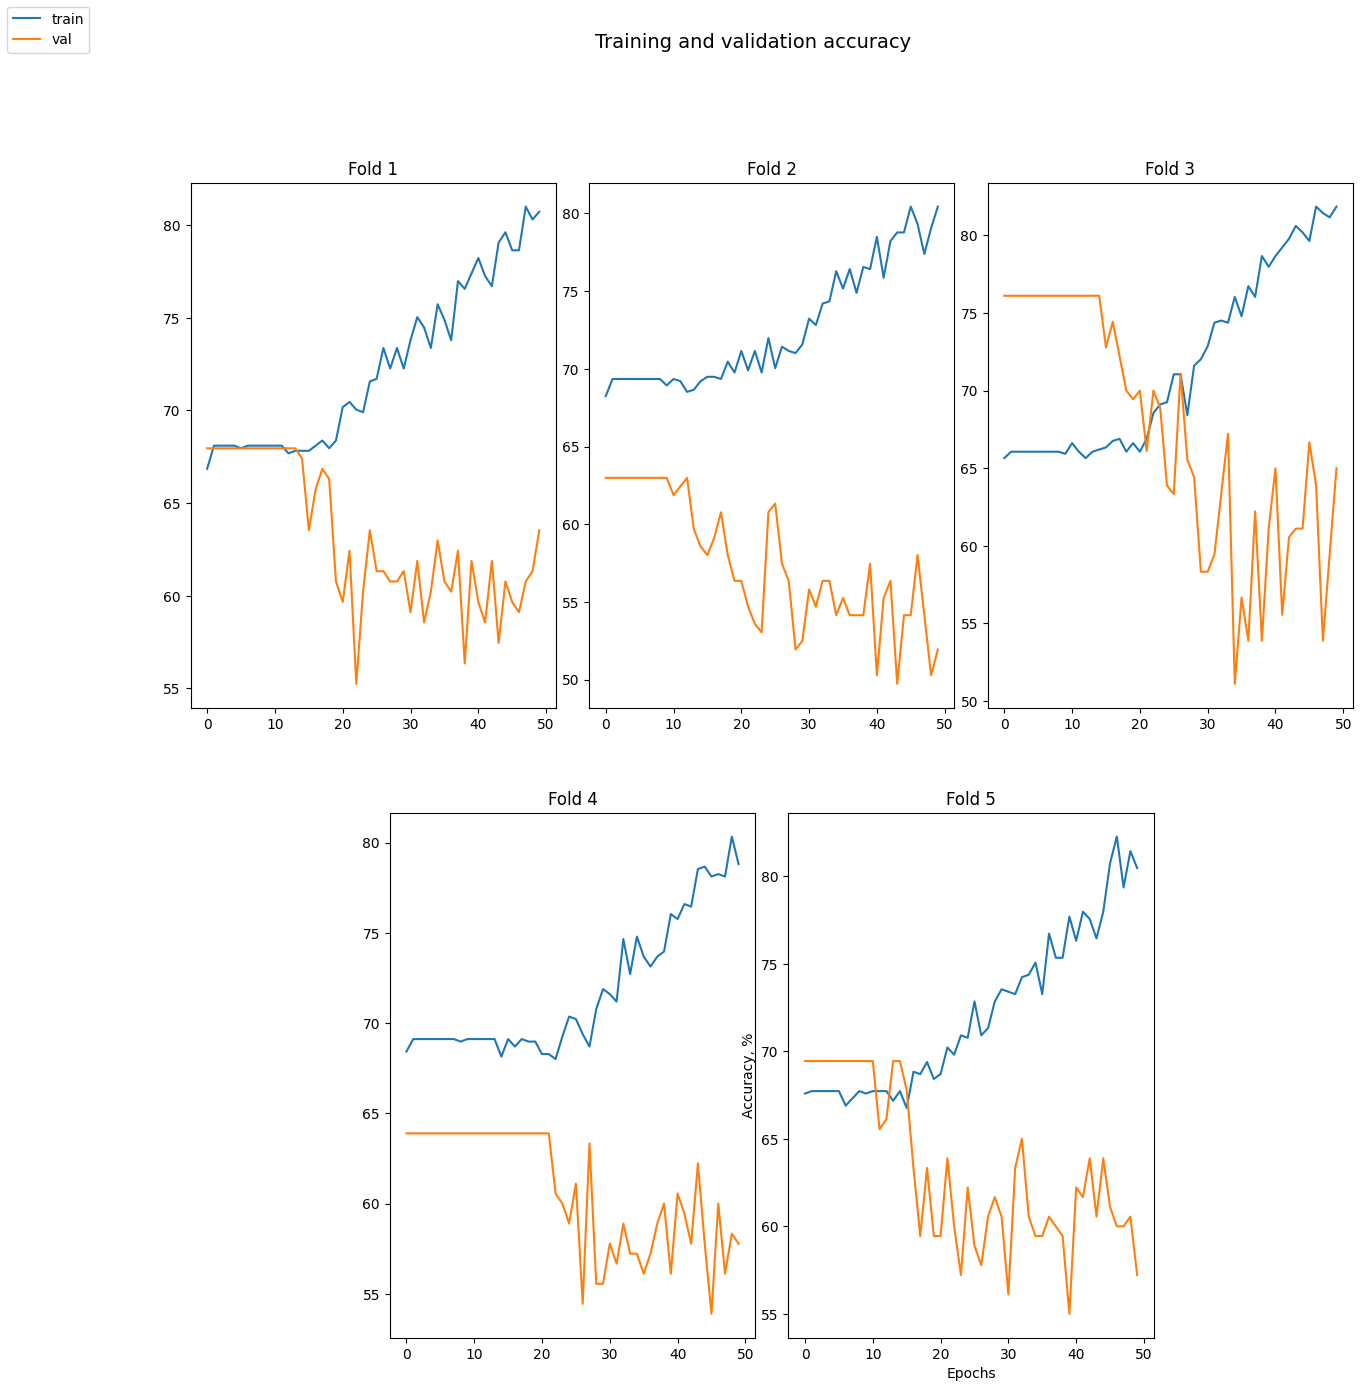

In [117]:
fig = plt.figure(figsize=(15, 15))

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)

ax1.plot(range(num_epochs), history['train_acc'][1], label='train')
ax2.plot(range(num_epochs), history['train_acc'][2])
ax3.plot(range(num_epochs), history['train_acc'][3])
ax4.plot(range(num_epochs), history['train_acc'][4])
ax5.plot(range(num_epochs), history['train_acc'][5])

ax1.plot(range(num_epochs), history['test_acc'][1], label='val')
ax2.plot(range(num_epochs), history['test_acc'][2])
ax3.plot(range(num_epochs), history['test_acc'][3])
ax4.plot(range(num_epochs), history['test_acc'][4])
ax5.plot(range(num_epochs), history['test_acc'][5])

ax1.set_title("Fold 1")
ax2.set_title("Fold 2")
ax3.set_title("Fold 3")
ax4.set_title("Fold 4")
ax5.set_title("Fold 5")


lines_labels = [ax1.get_legend_handles_labels() ]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper left')

plt.ylabel("Accuracy, %")
plt.xlabel("Epochs")
plt.suptitle("Training and validation accuracy", fontsize=14)
#plt.savefig("figures/train_val_acc_GCN_2048.png")
plt.show()

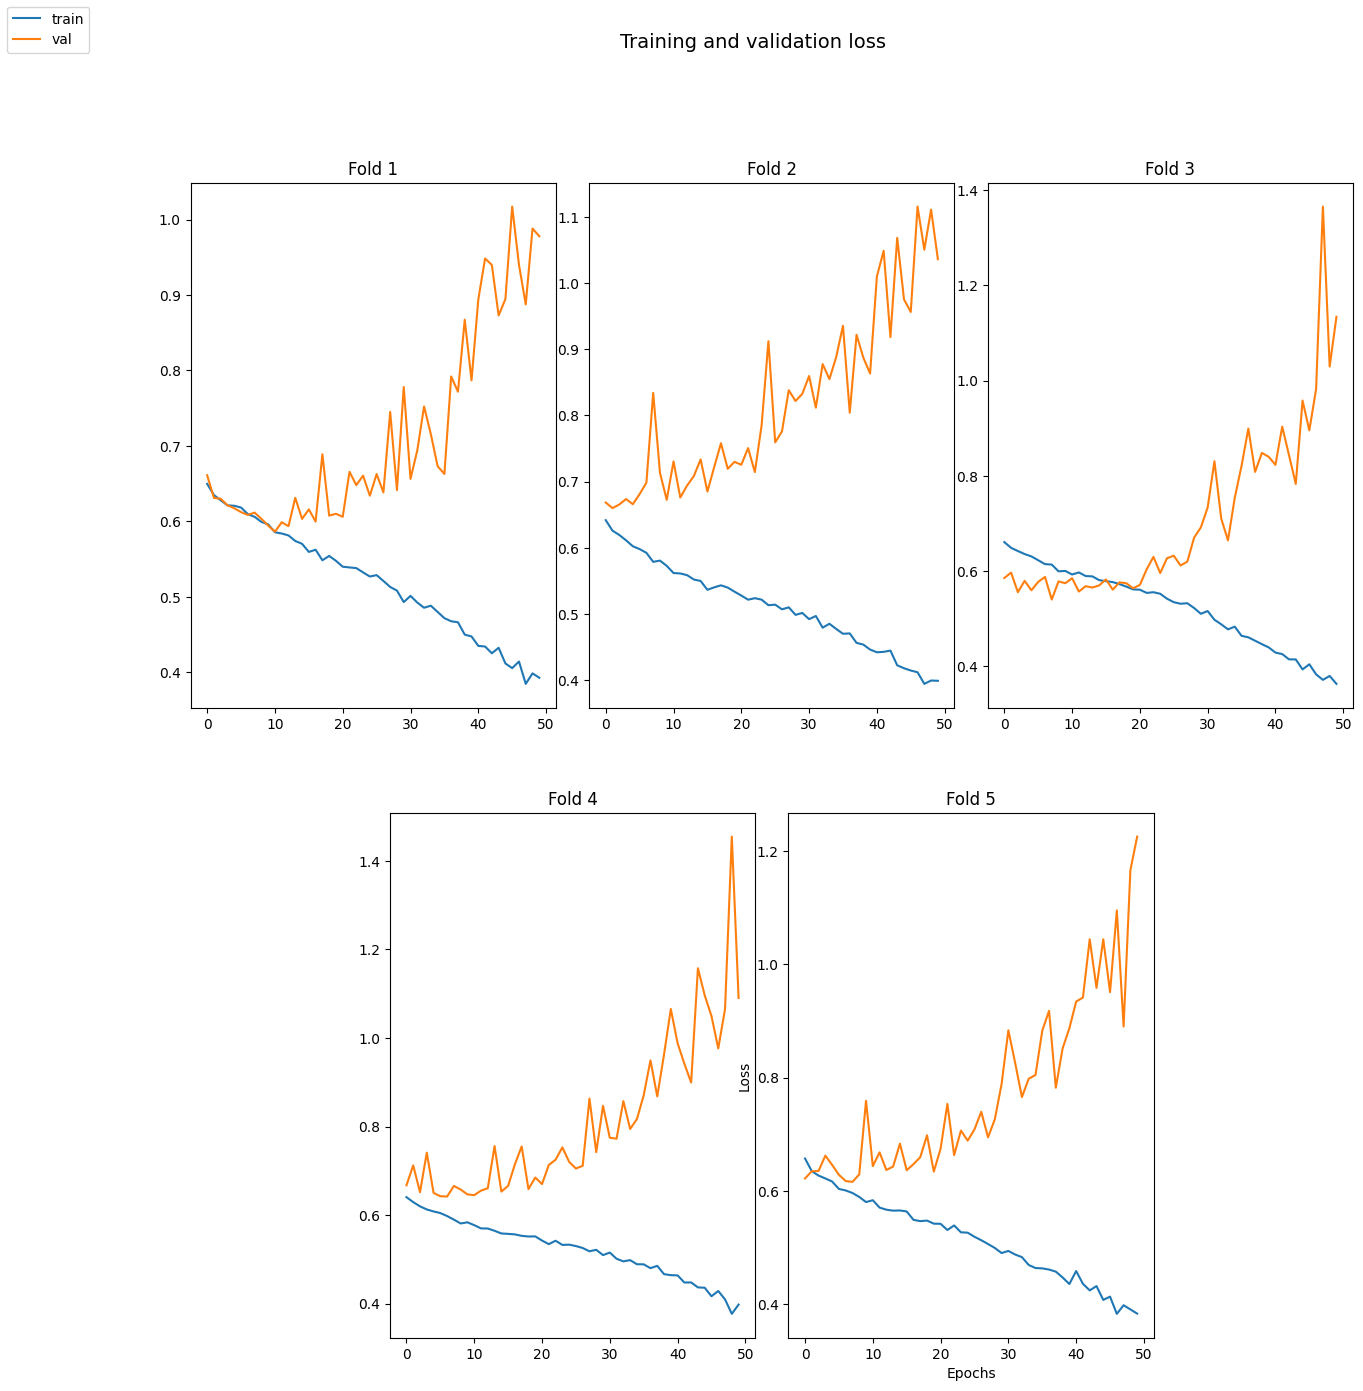

In [118]:
fig = plt.figure(figsize=(15, 15))

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)

ax1.plot(range(num_epochs), history['train_loss'][1], label='train')
ax2.plot(range(num_epochs), history['train_loss'][2])
ax3.plot(range(num_epochs), history['train_loss'][3])
ax4.plot(range(num_epochs), history['train_loss'][4])
ax5.plot(range(num_epochs), history['train_loss'][5])

ax1.plot(range(num_epochs), history['test_loss'][1], label='val')
ax2.plot(range(num_epochs), history['test_loss'][2])
ax3.plot(range(num_epochs), history['test_loss'][3])
ax4.plot(range(num_epochs), history['test_loss'][4])
ax5.plot(range(num_epochs), history['test_loss'][5])

ax1.set_title("Fold 1")
ax2.set_title("Fold 2")
ax3.set_title("Fold 3")
ax4.set_title("Fold 4")
ax5.set_title("Fold 5")


lines_labels = [ax1.get_legend_handles_labels() ]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper left')

plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.suptitle("Training and validation loss", fontsize=14)
#plt.savefig("figures/train_val_loss_GCN_2048.png")
plt.show()